In [1]:

import torch
import numpy as np
%load_ext autoreload
%autoreload 2
from utils import load_data,default_loader,trainset,imshow,normal,layershow
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from torchsummary import summary
import datetime
import time,datetime
from scipy.integrate import solve_ivp
from bokeh.io import  output_notebook, push_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import column, row
from bokeh.models import Label
from ipywidgets import interact, FloatSlider
from bokeh.palettes import Category10, Category20
output_notebook(hide_banner=True)

**Data Path**

In [2]:
datapath = ".."
data,paths,labels = load_data(datapath)
available_field = ['url','videoname','locs','frameids','label_names','crop','scale','origRes','isYouTubeSubset']


**shift the data**

In [3]:
num_data=len(paths)
index=np.arange(num_data)
np.random.shuffle(index)
paths=[paths[i] for i in index]
labels=[labels[i] for i in index]

**partition of the data into three part**

In [4]:
#how many data we will put into each set
train_num,val_num, test_num  = int(0.50*num_data),int(num_data*0.30),int(num_data*0.2)

assert(train_num+val_num+test_num<=num_data)
train_path,train_label=paths[0:train_num],labels[0:train_num]
val_path,  val_label  =paths[train_num:train_num+val_num],labels[train_num:train_num+val_num]
test_path, test_label =paths[train_num+val_num:],labels[train_num+val_num:]

train_data  = trainset(train_path,train_label)
trainloader = DataLoader(train_data, batch_size=4,shuffle=True)

val_data  = trainset(val_path,val_label)
valloader = DataLoader(val_data, batch_size=4,shuffle=True)

test_data  = trainset(test_path,test_label)
testloader = DataLoader(test_data, batch_size=4,shuffle=True)
print("number of data in the training set    :", len(train_data))
print("number of data in the validation set  :", len(val_data))
print("number of data in the test set        :", len(test_data))

number of data in the training set    : 2500
number of data in the validation set  : 1500
number of data in the test set        : 1000


In [5]:
label1=test_data[0][1]
label2=test_data[1][1]
new_w,new_h=256,256


'''input two heatmap:
size: 7*256*256
'''
def distance_max(P,Q):
    c,w,h=P.shape
    distance=[]
    
    Pp=torch.argmax(P.reshape(c,w*h),dim=1)
    Qp=torch.argmax(Q.reshape(c,w*h),dim=1)
    Pw,Ph=Pp/256,Pp%256
    Qw,Qh=Qp/256,Qp%256
    
    Pp=np.array([Pw.cpu().numpy(),Ph.cpu().numpy()])
    Qp=np.array([Qw.cpu().numpy(),Qh.cpu().numpy()])
    tmp=Pp-Qp
    tmp=np.sum(tmp**2,axis=0)
    
    return np.sqrt(tmp)

def batch_distance(Qb,Pb):
    dis=[]
    for i in range(Qb.shape[0]):
        dis.append(distance_max(Qb[i],Pb[i]))
    return np.array(dis)

**load example data from test set**

In [6]:
count = 1
for data in testloader:
    if count == 1:
        inputs_try,labels_try = data
    count +=1
print(count,"batches")   
print(inputs_try.shape)

251 batches
torch.Size([4, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


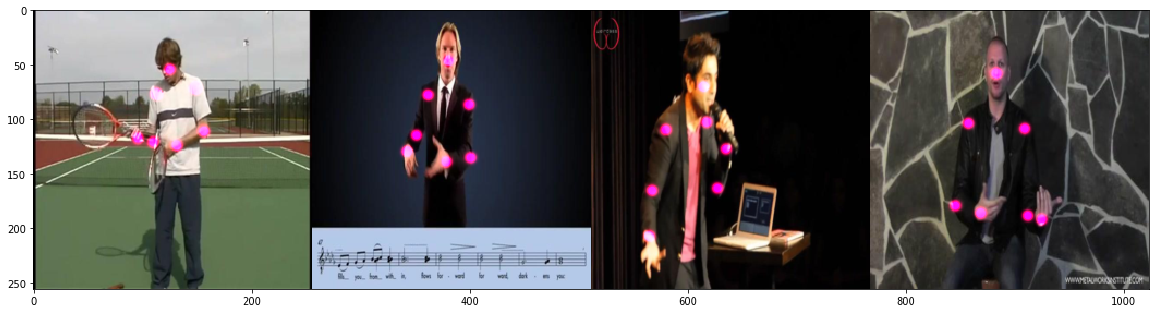

In [7]:
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,labels_try) 

In [16]:
use_gpu=torch.cuda.is_available()
use_gpu

True

In [17]:
?nn.Conv2d

Init signature:
nn.Conv2d(
    ['in_channels', 'out_channels', 'kernel_size', 'stride=1', 'padding=0', 'dilation=1', 'groups=1', 'bias=True'],
)
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:math:`H` is a height of input planes in pixels, and :math:`W` is
width in pixels.

* :attr:`stride` controls the stride for the cross-correlation, a single
  number or a tuple.

* :attr:`padding` controls the amount of implicit zero-pad

In [18]:
?nn.ConcatTable

Object `nn.ConcatTable` not found.


In [24]:
from torch.autograd import Variable
class ConcatTable(nn.Module):
    def __init__(self, module_list=None):
        super(ConcatTable, self).__init__()

        self.modules_list = nn.ModuleList(module_list)

    def forward(self, x: Variable):
        y = []
        for i in range(len(self.modules_list)):
            y.append(self.modules_list[i](x))
        return y

    def add(self, module):
        self.modules_list.append(module)


class CaddTable(nn.Module):
    def __init__(self, inplace=False):
        super(CaddTable, self).__init__()
        self.inplace = inplace

    def forward(self, x: Variable or list):
        return torch.stack(x, 0).sum(0)
    
class Identity(nn.Module):
    def __init__(self, params=None):
        super(Identity, self).__init__()
        self.params = nn.ParameterList(params)

    def forward(self, x: Variable or list):
        return x

def convBlock(numIn,numOut):
    l = []
    l.append(nn.BatchNorm2d(numIn))
    l.append(nn.ReLU(True))
    l.append(nn.Conv2d(numIn,int(numOut/2),kernel_size = 1,stride = 1))
    l.append(nn.BatchNorm2d(int(numOut/2)))
    l.append(nn.ReLU(True))
    l.append(nn.Conv2d(int(numOut/2),int(numOut/2),3,stride = 1, padding = 1))
    l.append(nn.BatchNorm2d(int(numOut/2)))
    l.append(nn.ReLU(True))
    l.append(nn.Conv2d(int(numOut/2),numOut,1,1))
    return nn.Sequential(*l)

def skipLayer(numIn,numOut):
    if numIn == numOut:
        return Identity()
    else:
        return nn.Sequential( conv(numIn,numOut,1,1))

def Residual(numIn,numOut):
    l = []
    addTable = ConcatTable()
    addTable.add(convBlock(numIn,numOut))
    addTable.add(skipLayer(numIn,numOut))
    l.append(addTable)
    l.append(CaddTable(True))
    return nn.Sequential(*l)



class Hourglass(nn.Module):
    def __init__(self,num_In,num_Out):
        super(Hourglass,self).__init__()
        self.up0 = nn.Sequential(nn.MaxPool2d(2),
                                 Residual(num_In,num_In))
        self.up1= nn.Sequential(nn.MaxPool2d(2),             #128
                                 Residual(num_In,num_In))
        #self.up1 = Residual(num_In,num_In)                     #64
        self.low1 = nn.Sequential(nn.MaxPool2d(2),
                                 Residual(num_In,num_In))      #32
        self.low2 = nn.Sequential(nn.MaxPool2d(2),
                                 Residual(num_In,num_In))      #16
        self.low3 = nn.Sequential(nn.MaxPool2d(2),
                                 Residual(num_In,num_In))      #8
        self.low4 = nn.Sequential(nn.MaxPool2d(2),
                                 Residual(num_In,num_In))      #4
        self.middle = nn.Sequential(Residual(num_In,num_In),
                                    Residual(num_In,num_In))
        self.up2 = nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2)
                                )      #8
        self.up3 = nn.Sequential(Residual(num_In,num_In),
                                 nn.UpsamplingNearest2d(scale_factor=2)
                                )      #16
        self.up4 = nn.Sequential(Residual(num_In,num_In),
                                 nn.UpsamplingNearest2d(scale_factor=2)
                                )      #32
        self.up5 = nn.Sequential(Residual(num_In,num_In),
                                 nn.UpsamplingNearest2d(scale_factor=2)
                                )      #64
        self.up6 = nn.Sequential(Residual(num_In,num_In),
                                 nn.UpsamplingNearest2d(scale_factor=2))
        self.up7 = nn.Sequential(Residual(num_In,num_In),
                                nn.UpsamplingNearest2d(scale_factor=2))
        self.up8 = nn.Sequential(Residual(num_In,num_In),
                                nn.UpsamplingNearest2d(scale_factor=2),
                                Residual(num_In,num_In))
    def forward(self,x):
        #print(x.shape)
        x0 = self.up0(x)
        x1 = self.up1(x0)    #64
        #print(x1.shape)
        x2 = self.low1(x1)   #32
        x3 = self.low2(x2)    #16
        x4 = self.low3(x3)    #8
        x5 = self.low4(x4)    #4
        x6 = self.middle(x5)  #4
        x_out = self.up2(x6)       #8
        #print("shape of up2x6 P{}".format(x.shape))
        x_out = x_out + x4
        x_out = self.up3(x_out)
        x_out = x_out + x3
        x_out = self.up4(x_out)
        x_out = x_out + x2
        x_out = self.up5(x_out)
        x_out = x_out + x1
        x_out = self.up6(x_out)
        x_out = x_out + x0
        x_out = self.up7(x_out)
        x_out = x_out + x
        x_out = self.up8(x_out)
        
        return x_out

class FinalModel(nn.Module):
    def __init__(self):
        super(FinalModel, self).__init__()
        self.conv1 = nn.Conv2d(3,256,3,stride=1,padding=1)
        self.hourglass = Hourglass(256,256)
        
        self.conv2=nn.Conv2d(256,128,3,stride=1,padding=1)
        self.conv3=nn.Conv2d(128,7,3,stride=1,padding=1)
    def forward(self,x):
        x = self.conv1(x)
        x = nn.MaxPool2d(2)(x)
        #x = Residual(256,256)(x)
        x = self.hourglass(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.conv3(x)
        #print(x.shape)
        
        x = x.view([-1,7,256*256])
        x = nn.Softmax(dim=2)(x)
        x = x.view([-1,7,256,256])
        
        return x

model = FinalModel()
model = nn.DataParallel(model)
#summary(model, (3, 256, 256))

In [25]:
plot_distance = 125
labels = ['Head', 'Right wrist', 'Left wrist', 'Right elbow', 'Left elbow', 'Right shoulder', 'Left shoulder']
def print_figure(distance):
    fig_sol = figure(x_range=(0, plot_distance), width=650, height=300, title="Solution")
    for i in range(7):
        d = distance[:,i]
        length_d = len(d)
        np.append(d,[plot_distance])
        counter = 0
        acc = []
        for j in range(plot_distance):
            while(counter<length_d and d[counter]<j):
                counter = counter+1
            acc.append(1.0*counter/length_d)
        fig_sol.line(range(plot_distance),acc,legend=labels[i],line_width=2,color=Category10[10][i])
    fig_sol.legend.location = "bottom_right"
    show(fig_sol)
            

In [26]:
def train(model,trainloader,loss_fn,optimizer):
    if use_gpu:
        model=model.to("cuda")
        
    model.train(True)
    optimizer = optimizer

    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    for data in trainloader:
        inputs, labels = data
        bs = labels.size(0)

        if use_gpu:
            inputs=inputs.cuda()
            labels=labels.cuda()


        outputs = model(inputs)
        #print(outputs.numpy()[0,0])
        #print(outputs.shape, labels.shape)
        loss = loss_fn(outputs,labels) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds=outputs.data
        # statistics
        running_loss += loss.data.item()
        if(size%int(len(trainloader)/5)==0 and size!=0):
            print(running_loss / size, size)
        size += bs
        
        
        size += bs
              
            
    epoch_loss = running_loss / size      
    return epoch_loss

def test(model,data_loader,loss_fn,optimizer):
    model.eval()
    if use_gpu:
        model=model.to("cuda")
    running_corrects = 0.0
    running_loss = 0.0
    size = 0
    distance = []
    with torch.no_grad():

        for data in data_loader:
            inputs, labels = data    
            
            bs = labels.size(0)

            if use_gpu:
                inputs=inputs.cuda()
                labels=labels.cuda()

            outputs = model(inputs)
            loss = loss_fn(outputs,labels) 
            
            distance.extend(batch_distance(outputs,labels))
            
            
            running_loss += loss.data.item()
            #running_corrects += torch.sum(preds == labels)
            size += bs
        
        
        out = torchvision.utils.make_grid(inputs_try.cpu(),padding=0)
        preds=model(inputs_try.cuda()).cpu()
        imshow(out,preds.cpu())

        epoch_loss = running_loss / size
        
    distance = np.array(distance)
    distance.sort(axis=0)
    print_figure(distance)
    return epoch_loss

In [29]:
pose_detection = model
# choose the appropriate loss
loss_fn = nn.MSELoss(reduction='sum')
#loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1e-7
# your SGD optimizer
#optimizer_cl = torch.optim.Adadelta(pose_detection.parameters(),lr = learning_rate)
optimizer = torch.optim.Adam(pose_detection.parameters(),lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
# and train for 10 epochs
l_t,l_v=[],[]
save_path = "./checkpoints/ckpts3.pt"

pose_detection.load_state_dict(torch.load(save_path))

70.67749053955077 1000
70.36935992431641 2000
70.2863755086263 3000
70.23899578857421 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


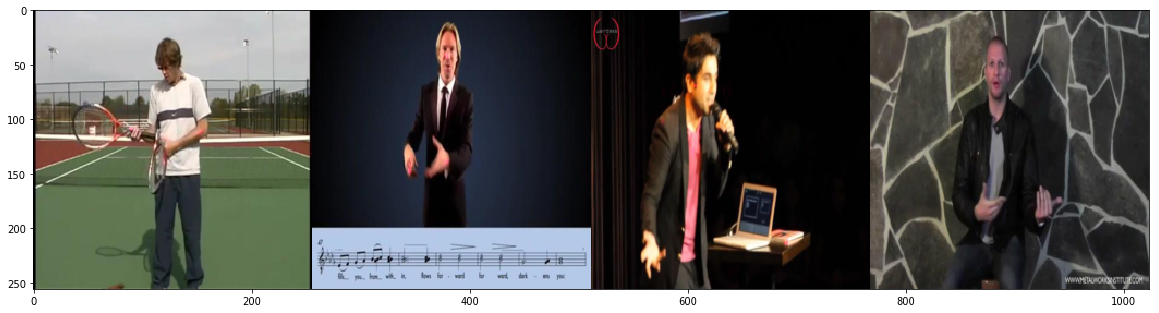

Epoch: 1  Train - Loss: 70.11 ; Validation - Loss: 142.32
Time consumed: 0:06:12.742589 Remaining time: 20:36:15.775258
70.66809069824218 1000
70.39144717407227 2000
70.26908915201822 3000
70.22275318908692 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


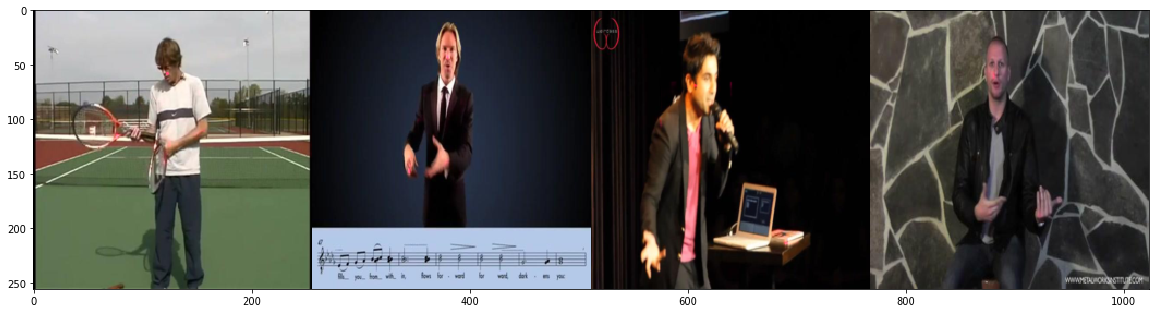

Epoch: 2  Train - Loss: 70.10 ; Validation - Loss: 142.22
Time consumed: 0:12:27.779537 Remaining time: 20:33:50.174136
70.65148370361328 1000
70.37372225952149 2000
70.26950376383463 3000
70.22008767700196 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


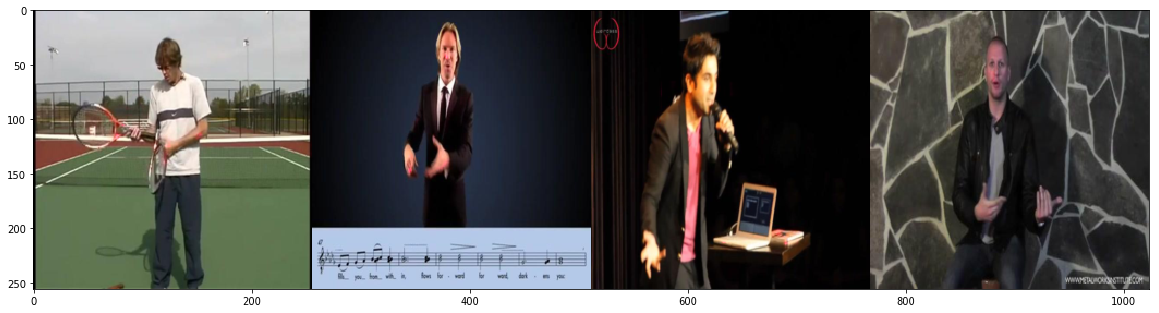

Epoch: 3  Train - Loss: 70.09 ; Validation - Loss: 142.26
Time consumed: 0:18:45.346896 Remaining time: 20:31:37.779531
70.60813537597656 1000
70.33897445678711 2000
70.2599868774414 3000
70.20980773925781 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


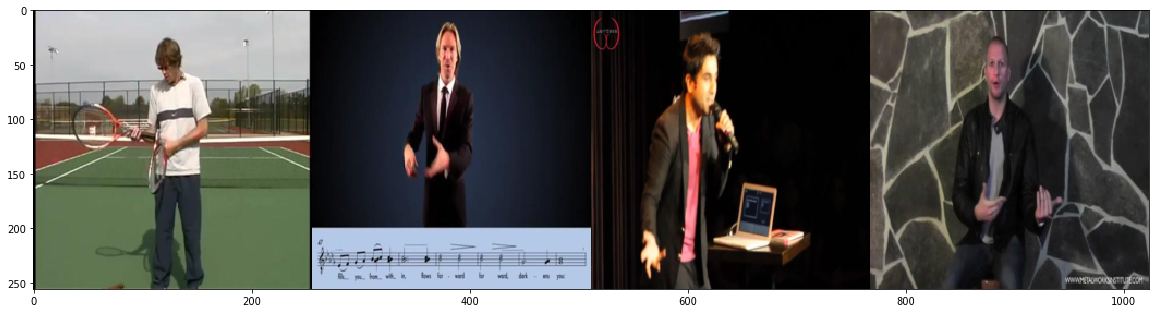

Epoch: 4  Train - Loss: 70.08 ; Validation - Loss: 142.18
Time consumed: 0:25:01.937765 Remaining time: 20:26:34.950491
70.56201007080078 1000
70.3474213256836 2000
70.25995088704427 3000
70.21413304138184 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


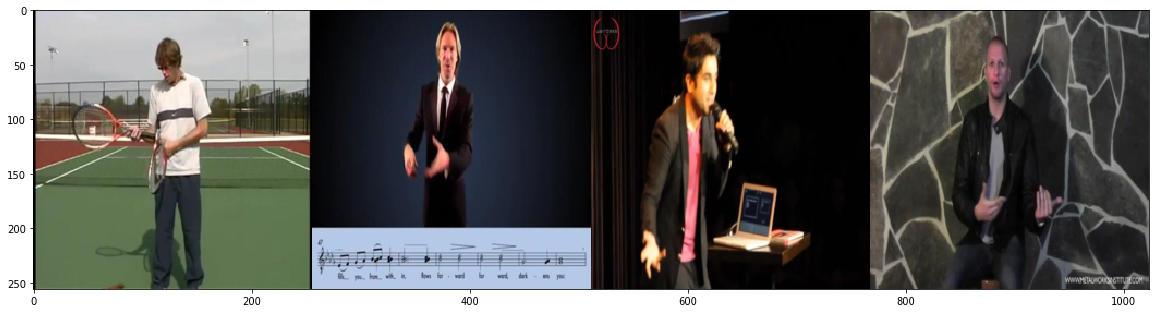

Epoch: 5  Train - Loss: 70.07 ; Validation - Loss: 142.28
Time consumed: 0:31:16.469236 Remaining time: 20:19:42.300191
70.67344403076171 1000
70.37441162109376 2000
70.26493868001302 3000
70.21552310180664 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


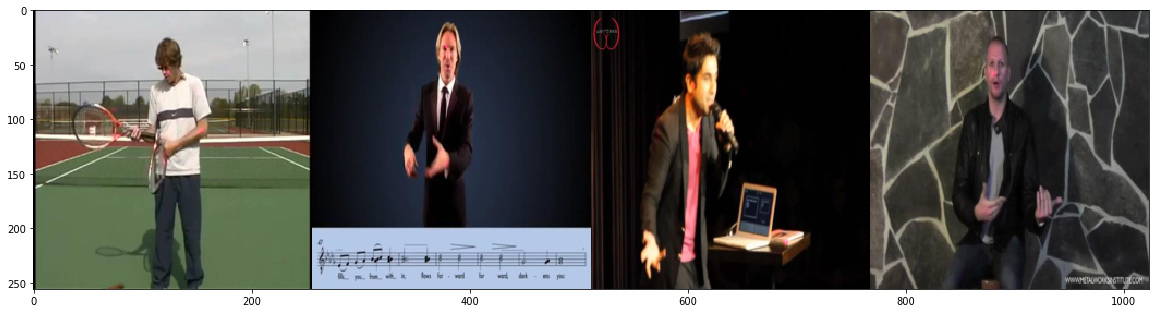

Epoch: 6  Train - Loss: 70.07 ; Validation - Loss: 142.11
Time consumed: 0:37:30.552361 Remaining time: 20:12:47.859673
70.63215728759765 1000
70.36038854980468 2000
70.25011458333333 3000
70.20880976867676 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


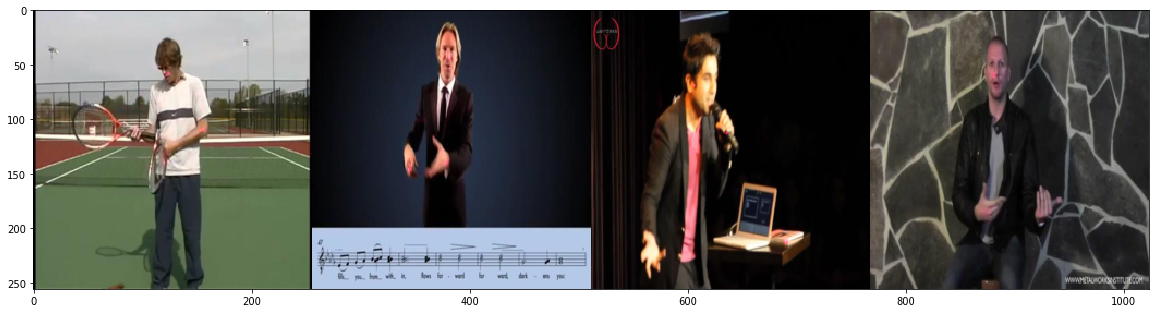

Epoch: 7  Train - Loss: 70.06 ; Validation - Loss: 142.17
Time consumed: 0:43:44.252062 Remaining time: 20:05:54.378270
70.65421350097657 1000
70.34293182373047 2000
70.2422089436849 3000
70.1977829284668 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


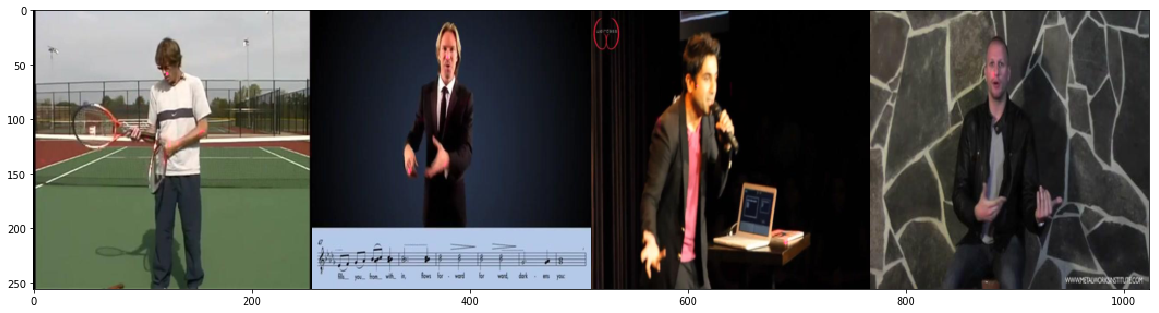

Epoch: 8  Train - Loss: 70.06 ; Validation - Loss: 142.17
Time consumed: 0:50:00.364174 Remaining time: 20:00:08.740179
70.5872939453125 1000
70.30281719970704 2000
70.23130053710938 3000
70.1830252532959 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


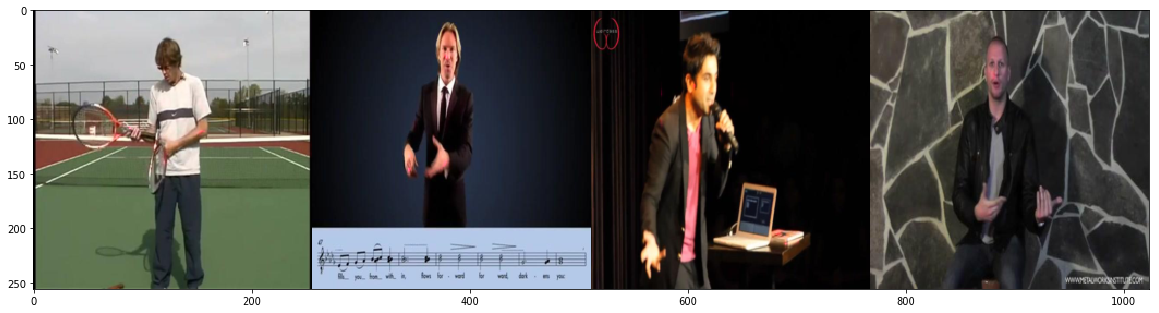

Epoch: 9  Train - Loss: 70.06 ; Validation - Loss: 142.31
Time consumed: 0:56:15.998770 Remaining time: 19:54:06.196119
70.62346124267579 1000
70.32945895385743 2000
70.24983707682291 3000
70.20962808227539 4000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


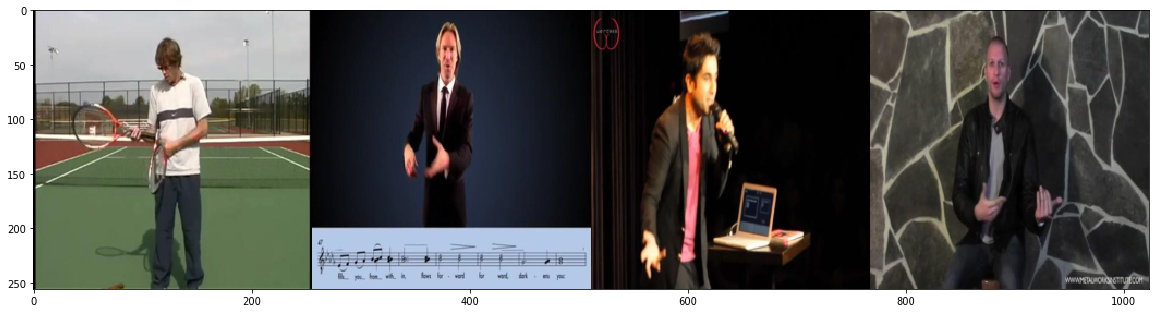

Epoch: 10  Train - Loss: 70.05 ; Validation - Loss: 142.28
Time consumed: 1:02:29.956285 Remaining time: 19:47:29.169424
70.62830279541015 1000
70.360146484375 2000
70.23551110839844 3000


KeyboardInterrupt: 

In [30]:
num_epoch=200

time_begin=time.time()

for epoch in range(num_epoch):
    scheduler.step()
    epoch_loss=train(pose_detection,trainloader,loss_fn,optimizer)
    val_loss  =test(pose_detection,valloader,loss_fn,optimizer)
    print('Epoch:',epoch+1, ' Train - Loss: {:.2f} ; Validation - Loss: {:.2f}'.format(epoch_loss,val_loss))
    l_t.append(epoch_loss)
    l_v.append(val_loss)
    now=time.time()
    time_used=now-time_begin
    time_remain= time_used /(epoch+1) *(num_epoch-1-epoch)
    torch.save(model.state_dict(), save_path)
    print("Time consumed:", datetime.timedelta(seconds=time_used), "Remaining time:", datetime.timedelta(seconds=time_remain))

In [ ]:
num_epoch=200

time_begin=time.time()

for epoch in range(num_epoch):
    scheduler.step()
    epoch_loss=train(pose_detection,trainloader,loss_fn,optimizer)
    val_loss  =test(pose_detection,valloader,loss_fn,optimizer)
    print('Epoch:',epoch+1, ' Train - Loss: {:.2f} ; Validation - Loss: {:.2f}'.format(epoch_loss,val_loss))
    l_t.append(epoch_loss)
    l_v.append(val_loss)
    now=time.time()
    time_used=now-time_begin
    time_remain= time_used /(epoch+1) *(num_epoch-1-epoch)
    torch.save(model.state_dict(), save_path)
    print("Time consumed:", datetime.timedelta(seconds=time_used), "Remaining time:", datetime.timedelta(seconds=time_remain))

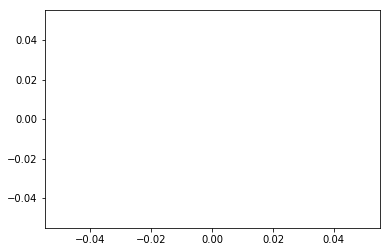

In [148]:
plt.plot(range(len(l_t)),l_t,l_v)

In [ ]:
preds.shape ,labels_try.shape

In [ ]:
with torch.no_grad():
    preds=pose_detection(inputs_try.cuda()).cpu()
out = torchvision.utils.make_grid(inputs_try,padding=0)
imshow(out,preds) 
imshow(out,labels_try) 